In [0]:
import pandas as pd
import numpy as np
import keras
import sklearn
from keras import optimizers
import nltk
import string as st
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM,GRU,Dense,Embedding,RepeatVector,TimeDistributed,Dropout,Bidirectional
from nltk.translate.bleu_score import corpus_bleu
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

In [0]:
# Data will be in txt format.So, convert data in to dataframe using pandas 
data = pd.read_csv('deu.txt', delimiter='\t', names=['English', 'German'])
data_copy=data

In [0]:
reduced_data_set=data_copy[:160000]

In [0]:
# Reduced data size
reduced_data_set=reduced_data_set.reset_index(drop=True)

**Data preprocessing**

In [0]:
en_max_len=0
deu_max_len=0
# lang_max_len=0
# Remove punctuations in all the records. 
#Also, find the record with the maximum word length in both the languages.
#This is done to create a fized encoding length for both the languages.
for index, row in reduced_data_set.iterrows():
    row['English']=row['English'].translate(str.maketrans('', '', st.punctuation)).lower()
    if len(row['English'].split())>en_max_len:
        en_max_len=len(row['English'].split())
    row['German']=row['German'].translate(str.maketrans('', '', st.punctuation)).lower()
    if len(row['German'].split())>deu_max_len:
        deu_max_len=len(row['German'].split())  
    # if deu_max_len > en_max_len:
    #     lang_max_len=deu_max_len
    # else:
    #     lang_max_len=en_max_len

In [168]:
#Map the words to integers using keras based tokenizer
en_tokenizer=Tokenizer()
deu_tokenizer=Tokenizer()

en_tokenizer.fit_on_texts(reduced_data_set['English'].to_numpy())
en_vocabulary_size = len(en_tokenizer.word_index) + 1

deu_tokenizer.fit_on_texts(reduced_data_set['German'].to_numpy())
deu_vocabulary_size = len(deu_tokenizer.word_index) + 1

print('English Vocabulary Size:', en_vocabulary_size)
print('Deutch Vocabulary Size:',deu_vocabulary_size)

English Vocabulary Size: 12820
Deutch Vocabulary Size: 25698


**Split data in to training data and test data**

In [0]:
#Split the data in to ~80% for training set and ~20% for testing set
data_split = np.random.rand(len(reduced_data_set)) <= 0.9
train_data = reduced_data_set[data_split]
test_data = reduced_data_set[~data_split]

In [0]:
# train_data = reduced_data_set[:100000]
# test_data = reduced_data_set[100000:120000]

In [171]:
#Shape of the training set and test set
print(train_data.shape)
print(test_data.shape)

(144046, 2)
(15954, 2)


**Convert data in to numpy array**

In [0]:
#Convert dataframe in to numpy array
train_data_np=train_data.to_numpy()
test_data_np=test_data.to_numpy()

**Encode and split the data in to training and test data**

In [0]:
# Convert text in to encoded numbers. Also, padding is done with zeroes to maintain equal length for both languagge data.
def encode_data(language_tokenizer, length, all_data):
    encoded_data = language_tokenizer.texts_to_sequences(all_data)
    padded_data = pad_sequences(encoded_data, maxlen=length, padding='post')
    return padded_data

trainX = encode_data(deu_tokenizer, deu_max_len, train_data_np[:, 1])
trainY = encode_data(en_tokenizer, en_max_len, train_data_np[:, 0])
testX = encode_data(deu_tokenizer, deu_max_len, test_data_np[:, 1])
testY = encode_data(en_tokenizer, en_max_len, test_data_np[:, 0])

In [0]:
#Convert mapped words in to normal words
def convert_integers_to_words(word_index, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == word_index:
            return word
    return None

**Decode the predictions after training of model is finished**

In [0]:
# Decode the predictions in to words
def decode_data(model_prediction):
    prediction_text=list()
    for sentence in prediction:
        converted_sentence = list()
        for word_index in range(len(sentence)):
            word = convert_integers_to_words(sentence[word_index], en_tokenizer)
            if word_index > 0:
                if (word == convert_integers_to_words(sentence[word_index-1], en_tokenizer)) or (word == None):
                    converted_sentence.append('')
                else:
                    converted_sentence.append(word)

            else:
                if(word == None):
                    converted_sentence.append('')
                else:
                    converted_sentence.append(word)            

        prediction_text.append(' '.join(converted_sentence))
        
    return prediction_text

In [0]:
#Build a sequence model using keras
def build_model(lang1_vocab, lang2_vocab, lang1_max_len, lang2_max_len, units):
    model = Sequential()
    model.add(Embedding(lang1_vocab, units, input_length=lang1_max_len,input_shape=(lang1_max_len,), mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(lang2_max_len))
    model.add((LSTM(units, return_sequences=True)))
    model.add(Dense(lang2_vocab, activation='softmax'))
    return model

In [0]:
model = build_model(deu_vocabulary_size, en_vocabulary_size, deu_max_len, en_max_len, 512)
rms_optimizer = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms_optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [178]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 19, 512)           13157376  
_________________________________________________________________
lstm_11 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 11, 512)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 11, 512)           2099200   
_________________________________________________________________
dense_8 (Dense)              (None, 11, 12820)         6576660   
Total params: 23,932,436
Trainable params: 23,932,436
Non-trainable params: 0
_________________________________________________________________


In [0]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [180]:
history=model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),epochs=20, batch_size=512, validation_split = 0.1, callbacks=[checkpoint], verbose=1)

Train on 129641 samples, validate on 14405 samples
Epoch 1/20
129641/129641 [==============================] - 57s 437us/step - loss: 3.1059 - acc: 0.5575 - val_loss: 4.2875 - val_acc: 0.3674

Epoch 00001: val_loss improved from inf to 4.28753, saving model to model.h5
Epoch 2/20
129641/129641 [==============================] - 49s 381us/step - loss: 2.6030 - acc: 0.5959 - val_loss: 4.1089 - val_acc: 0.4002

Epoch 00002: val_loss improved from 4.28753 to 4.10890, saving model to model.h5
Epoch 3/20
129641/129641 [==============================] - 49s 381us/step - loss: 2.2656 - acc: 0.6351 - val_loss: 3.8988 - val_acc: 0.4253

Epoch 00003: val_loss improved from 4.10890 to 3.89882, saving model to model.h5
Epoch 4/20
129641/129641 [==============================] - 49s 379us/step - loss: 1.9675 - acc: 0.6693 - val_loss: 3.4299 - val_acc: 0.4606

Epoch 00004: val_loss improved from 3.89882 to 3.42994, saving model to model.h5
Epoch 5/20
129641/129641 [==============================] - 4

In [0]:
#Get predictions for text data 
model=load_model('model.h5')
prediction = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

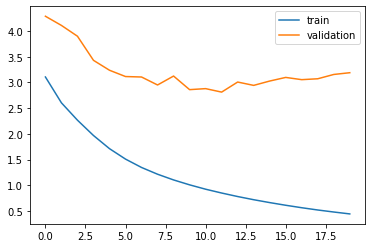

In [182]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [0]:
#Decode the predictions
prediction_text = decode_data(prediction)
#Create a new dataframe for expected and predicted data
pred_df = pd.DataFrame({'German':test_data['German'],'Expected' : test_data['English'], 'predicted' : prediction_text})

In [198]:
#Display the expected and predicted data
pred_df.iloc[7:12]

,German,Expected,predicted
71,seien sie nett,be nice,be nice
85,schwirr ab,beat it,get away
114,mach ’ne fliege,go away,get away
117,scher dich weg,go away,get away
120,verpiss dich,go away,get lost


In [197]:
pred_df.iloc[9000:9005]

,German,Expected,predicted
90478,wozu brauchtest du eine kettensäge,why did you need a chainsaw,why did you need a chainsaw
90482,wozu habt ihr eine kettensäge gebraucht,why did you need a chainsaw,why did you need a chainsaw
90484,warum hast du das zu tom gesagt,why did you say that to tom,why did you tell tom to
90507,warum hast du mir das nicht gesagt,why didnt you tell me that,why didnt you tell me
90514,warum tun die menschen böses,why do people do bad things,why are people


In [0]:
def evaluate_model(actual_data,predicted_data):
    print('BLEU Score:',corpus_bleu(actual_data, prediction_text))

In [203]:
evaluate_model(test_data_np[:,0],prediction_text)

BLEU Score: 0.7977105212768360
